# PeDistance Linear Regression

### Initial settings

#### Dependencies

In [8]:
# YOLOv5 install dependencies
%pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [36]:
#imutils
%pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25862 sha256=7733e078c9febc06608efffe27fb8d0019553d12b93ffac9c3051bdc03a9096b
  Stored in directory: c:\users\alessandro\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


#### Imports and Utilities

In [2]:
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import base64
from PIL import Image
import cv2
from pathlib import Path
from __future__ import print_function
import imutils
from imutils.object_detection import non_max_suppression
from imutils import paths
import argparse
import matplotlib.image as mpimg
import io

In [3]:
# Used as file name where saving model state
model_file_name="reg_state.pth"

# Get device based on available hardware
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# Convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.to_numpy()).float().to(device)

### Import Dataset

In [4]:
# Filtered fields read from dataset csv file
fields = [
    'Distance', 
    'PedTopLeftX', 
    'PedTopLeftY', 
    'PedTopRightX', 
    'PedTopRightY',
    'PedBottomLeftX', 
    'PedBottomLeftY',
    'PedBottomRightX',
    'PedBottomRightY',
    'B64File'
]

df = pd.read_csv (r'./Dataset.csv', usecols=fields)
print(df.shape)

(42, 10)


### Normalize input feature 

In [5]:
def get_image_resolution(b64string):
    image = base64.b64decode(b64string)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format='JPG')
    return image.shape
    
testone = df['B64File'][0]    
get_image_resolution(testone)

(1080, 1920, 3)

### Splitting dataset


In [8]:
# sklearn function to split pandas dataframe into train and test set
train, test = train_test_split(df, test_size = 0.3)
train = shuffle(train)

In [9]:
# parsing dataframes to pytorch tensor
Y_training = df_to_tensor(train.Distance)
Y_testing = df_to_tensor(test.Distance)

print(Y_training.shape)
print(Y_testing.shape)

torch.Size([29])
torch.Size([13])


In [10]:
# normalizzare l'immagine (ridurre size)

#### Getting width  height from raw 2D screen points

In [27]:
def get_resized_box_dim(el):
    width = abs(el.PedTopRightX - el.PedTopLeftX)
    height = abs(el.PedBottomLeftY - el.PedTopLeftY)
    res = get_image_resolution(el.B64File)
    width = int((width * 640) / res[1])
    height = int((height * 360) / res[0])
    return width, height

In [32]:
X_training = df_to_tensor(train.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))
X_testing = df_to_tensor(test.apply(lambda el :  pd.Series(get_resized_box_dim(el), index=['width', 'height']), axis=1))

print(X_training.shape)
print(X_testing.shape)

torch.Size([29, 2])
torch.Size([13, 2])


### Linear Regression Module

In [10]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinearRegressor, self).__init__()
        self.criterion = nn.MSELoss()
        self.linear = nn.Linear(in_size,out_size)       
        
    # used to train linear regressor
    def fit(self, X_training, Y_training, X_testing, Y_testing, lr= 0.001, epochs=200000, momentum=0.0, reset_parameters= False):
        self.reset_parameters(reset_parameters)
        
        self.mean = X_training.mean(0)
        self.stds = X_training.std(0)
        X_training_norm = self._data_normalization(X_training)
        X_testing_norm = self._data_normalization(X_testing)
                
        self.optimizer = torch.optim.SGD(reg.parameters(), lr=lr, momentum=momentum)
        self.writer = SummaryWriter('logs/linear_regressor_lr' + str(lr) + '_momentum' + str(momentum) + '_epochs' + str(epochs))
        
        self._training(X_training_norm, Y_training, X_testing_norm, Y_testing, lr, epochs, momentum)
       
    def _training(self, X_training_norm, Y_training, X_testing_norm, Y_testing, l, epochs, momentum):
       
        for e in range(epochs):   
            reg.train()
            preds_train = self.forward(X_training_norm)
            l = self.criterion(preds_train.view(-1),Y_training)

            self.writer.add_scalar('loss/train', l.item(), global_step=e)

            l.backward()

            self.optimizer.step()    
            self.optimizer.zero_grad()
            
            reg.eval()
            with torch.set_grad_enabled(False):
                preds_test = self.forward(X_testing_norm)
                l = criterion(preds_test.view(-1),Y_testing)
                writer.add_scalar('loss/test', l.item(), global_step=e)    
        
    # used to get prediction based on trained linear regressor
    def predict(self, X):  
        X_norm = self._data_normalization(X)
        return self.linear(X_norm)
       
    # used to get final score tensor and predicted tensor based on train or test features and labels
    def score(self, X, Y):
        Y_preds = self.predict(X)
        l = self.criterion(Y_preds.view(-1),Y)
        return l, Y_preds
    
    # used to reset parameters before training
    def reset_parameters(self, reset_parameters= False):
        if reset_parameters:
            for layer in self.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
    
    # used to load parameters and model state to make predictions or continue training
    def load_state(self, path):
        if Path(path).exists():
            checkpoint = torch.load(path, map_location=get_device())
            self.mean = checkpoint["mean"]
            self.stds = checkpoint["stds"]
            self.load_state_dict(checkpoint["model_state_dict"])
    
    # used to save trained model state
    def save_state(self, path):
         torch.save({
            'mean': self.mean,
            'stds': self.stds,
            'model_state_dict': self.state_dict(),
            }, path)
        
    def _data_normalization(self, data):
        return (data-self.mean)/self.stds        
    
    def forward(self,x):
        result = self.linear(x)
        return result    

### Modular Linear Regression

In [11]:
reg = LinearRegressor(2,1).to(get_device())

In [12]:
reg.load_state(model_file_name)

In [17]:
reg.fit(X_training, Y_training, X_testing, Y_testing,)
reg.save_state(model_file_name)

In [29]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23584), started 1 day, 0:45:59 ago. (Use '!kill 23584' to kill it.)

In [36]:
loss_train, Y_train_preds = reg.score(X_training, Y_training)
print("Loss train: " + str(loss_train.item()))
for p,c in zip(Y_training, Y_train_preds):
      print([p.item(), c.item()])

Loss train: 17.227087020874023
[16.523662567138672, 16.3919620513916]
[17.42505645751953, 16.980361938476562]
[14.582019805908203, 15.780875205993652]
[7.662096977233887, 9.328457832336426]
[12.856714248657227, 14.891416549682617]
[9.105191230773926, 11.220478057861328]
[6.816208839416504, 7.42278528213501]
[11.18374252319336, 13.368316650390625]
[20.35521697998047, 17.670654296875]
[6.807604789733887, 7.504365921020508]
[9.6747407913208, 11.118719100952148]
[16.390705108642578, 16.224449157714844]
[11.812871932983398, 13.637654304504395]
[16.363496780395508, 16.380619049072266]
[15.827757835388184, 16.18144989013672]
[11.949706077575684, 13.257390022277832]
[46.93051528930664, -31.195575714111328]
[19.439638137817383, 17.326595306396484]
[8.89864730834961, 10.376394271850586]
[15.60302448272705, 16.057004928588867]
[12.037344932556152, 13.983887672424316]
[14.072953224182129, 15.350885391235352]
[16.02073860168457, 15.6654634475708]
[8.08452033996582, 10.034577369689941]
[12.724309921

In [37]:
loss_testing, Y_testing_preds = reg.score(X_testing, Y_testing)
print("Loss testing: " + str(loss_testing.item()))
for p,c in zip(Y_testing, Y_testing_preds):
    print([p.item(), c.item()])

Loss testing: 2.825904130935669
[8.296296119689941, 9.634000778198242]
[16.980440139770508, 16.69974708557129]
[11.1770658493042, 13.046878814697266]
[16.35079002380371, 16.396446228027344]
[8.971840858459473, 11.177545547485352]
[7.947657108306885, 9.421248435974121]
[12.947230339050293, 14.314292907714844]
[19.182199478149414, 17.30852508544922]
[14.033038139343262, 15.199201583862305]
[21.678512573242188, 17.44886589050293]
[14.104645729064941, 14.640214920043945]
[7.205693244934082, 6.725833892822266]
[13.108061790466309, 14.834831237792969]
[19.329179763793945, 17.491798400878906]
[13.224498748779297, 14.029194831848145]
[16.05987548828125, 15.685842514038086]
[8.062932968139648, 9.427974700927734]
[7.4869065284729, 8.737682342529297]
[7.328526020050049, 8.224138259887695]
[18.878908157348633, 17.34248924255371]
[8.484281539916992, 10.451047897338867]
[5.967748641967773, 4.777230262756348]
[14.126237869262695, 15.0068941116333]
[18.73735809326172, 16.677059173583984]
[17.765316009

## YOLOv5

In [39]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\danil/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-21 torch 1.8.0 CUDA:0 (NVIDIA GeForce RTX 2060, 6144.0MB)



### Get boxes from image

In [43]:
# Images
# img = plt.imread('lena.png')
img = Image.open('Test8.jpg').convert("RGB")
#imgs = ['https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png']  # batch of images
imgs = img

# Inference
results = model(imgs)

# Salva i risultati nella cartella corrente, inutile 
# results.print()
# results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)

results.pandas().xyxy[0]  # img1 predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,1370.25,441.0,1428.75,602.25,0.727539,0,person


### Get predictions

In [44]:
box_img = np.asarray(img)
person_box = []
person_box_size = []
obj_recognized = results.xyxy[0].cpu().numpy()

for obj in obj_recognized:
    if obj[5] == 0:
        person_box.append([obj[0], obj[1], obj[2], obj[3]])   
        person_box_size.append([abs(obj[2] - obj[0]), abs(obj[3] - obj[1])])

y_pred = reg.predict(torch.tensor(person_box_size).to(get_device())).squeeze(1).cpu().detach().numpy()
print(y_pred)
data = pd.DataFrame({'Prediction (m)': y_pred})
print(data)

[     14.948]
   Prediction (m)
0       14.947984


### Drawing boxes

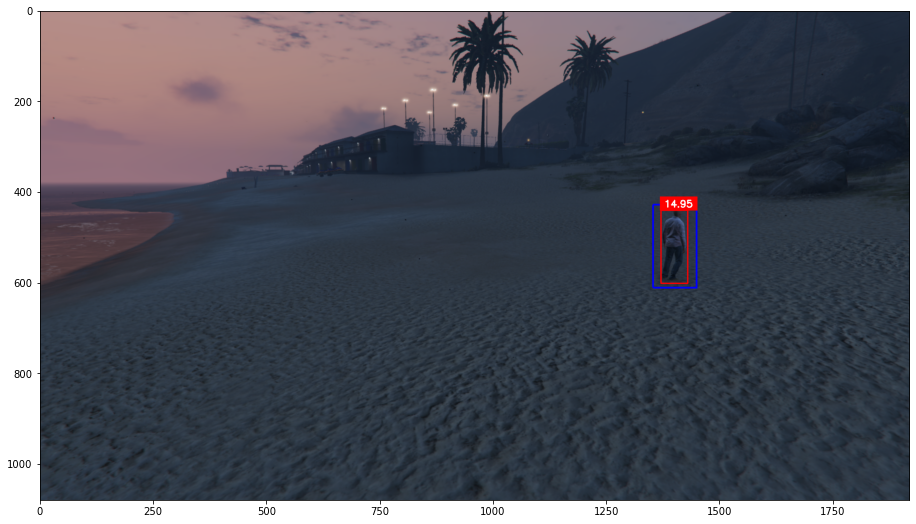

In [45]:
boxes = np.column_stack((person_box, y_pred))

for box in boxes:   
    cv2.rectangle(box_img, (round(box[0]),round(box[1])), (round(box[2]),round(box[3])), (255, 0, 0), 2)
    cv2.rectangle(box_img, (round(box[0]) - 2, round(box[1]) - 30), (round(box[0]) + 80, round(box[1])), (255, 0, 0), -1)
    cv2.putText(box_img, str(round(box[4], 2)), (round(box[0]) + 7, round(box[1]) - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(box_img)